The theory for this notebook is developed in `ZonotopesNonlinearReach`.

In [18]:
# load packages
using Plots
using LazySets, MathematicalSystems, Reachability
using LazySets.Approximations
using Reachability: center
using Reachability.ReachSets: Φ₁
using IntervalArithmetic, ValidatedNumerics
using LazySets: Interval, translate
using TaylorSeries
using TaylorSeries: gradient, jacobian, hessian, derivative
const ∂ = derivative

derivative (generic function with 10 methods)

In [228]:
#using VectorOfArray

ArgumentError: ArgumentError: Package VectorOfArray not found in current path:
- Run `import Pkg; Pkg.add("VectorOfArray")` to install the VectorOfArray package.


After loading the packages, you should precompile the functions under the section *auxiliary functions* below.

In [235]:
function vanderpol_ASB08()
    # number of Taylor terms considered in the linearization
    taylor_terms = 4

    # define the working variables and fix the max order in the Taylor series expansion
    x = set_variables("x", numvars=2, order=taylor_terms)

    # define the ODE
    f = Vector{TaylorN{Float64}}(undef, 2)
    f[1] = x[2]
    f[2] = x[2] * (1-x[1]^2) - x[1]

    # define the initial-value problem
    
    𝑋₀ = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45])
    
    #𝑋₀ = convert(Zonotope, 𝑋₀)
    #𝑋₀ = split(𝑋₀, [10, 10])[1] # temp
    
    𝑆 = BlackBoxContinuousSystem(f, 2)
    𝑃 = InitialValueProblem(𝑆, 𝑋₀)
    𝑂 = Options(:δ => 0.01, :δcont => 0.01/10, :max_order=>2, :θ=>fill(0.05, 2), :taylor_terms=>taylor_terms,
                :T => 7.0, :plot_vars=>[1, 2],
                :opC => "BFFPSV18", :split_blocks=>[2, 2], :max_chunks=>5000)
    return 𝑃, 𝑂
end

vanderpol_ASB08 (generic function with 1 method)

In [236]:
@time begin 𝑃, 𝑂 = vanderpol_ASB08() end

  0.113574 seconds (263.19 k allocations: 14.128 MiB)


(InitialValueProblem{BlackBoxContinuousSystem{Array{TaylorN{Float64},1}},Hyperrectangle{Float64}}(BlackBoxContinuousSystem{Array{TaylorN{Float64},1}}(TaylorN{Float64}[ 1.0 x₂ + 𝒪(‖x‖⁵),  - 1.0 x₁ + 1.0 x₂ - 1.0 x₁² x₂ + 𝒪(‖x‖⁵)], 2), Hyperrectangle{Float64}([1.4, 2.4], [0.15, 0.05])), Options(Dict{Symbol,Any}(:T=>7.0,:δcont=>0.001,:max_order=>2,:opC=>"BFFPSV18",:split_blocks=>[2, 2],:max_chunks=>5000,:taylor_terms=>4,:δ=>0.01,:θ=>[0.05, 0.05],:plot_vars=>[1, 2]…)))

### Algorithm

In [237]:
function post(𝑃::InitialValueProblem{<:BBCS}, 𝑂::Options)

    # get nonlinear ODE
    f = 𝑃.s.f
    
    # unrwap commonly used options
    δ = 𝑂[:δ]
    δcont = 𝑂[:δcont]
    θ = 𝑂[:θ]
    T = 𝑂[:T]
    opC = 𝑂[:opC]
    split_blocks = 𝑂[:split_blocks]
    max_chunks = 𝑂[:max_chunks]
    
    # general options for the continuous post
    𝑂cont = Options(:T=>δ)

    # algorithm-specific options for the continuous post
    𝑂_GLGM06 = Options(:δ=>𝑂[:δcont], :max_order=>𝑂[:max_order])
    𝑂_BFFPSV18 = Options(:δ=>𝑂[:δcont])
    
    # final result is stored in Rsets
    if opC == "GLGM06"
        Rsets = Vector{ReachSet{Zonotope{Float64}, Float64}}()
    elseif opC == "BFFPSV18" 
        Rsets = Vector{ReachSet{Hyperrectangle{Float64}, Float64}}()
    end

    t0 = 0.0 # initial time for each chunk

    # count number of continuous post chunks added to Rsets
    nchunks = 0

    𝑃_queue = Vector{typeof(𝑃)}()
    push!(𝑃_queue, 𝑃)

    t0_queue = Vector{Float64}()
    push!(t0_queue, t0)

    while !isempty(𝑃_queue)
        println("length(𝑃_queue) = $(length(𝑃_queue))")
        𝑃_curr = pop!(𝑃_queue)
        t0_curr = pop!(t0_queue)

        # obtain linearized system
        x̃, 𝑃lin = linearize(𝑃_curr, δ)

        # compute flowpipe of the linearized system
        if opC == "GLGM06"
            Rlin = solve(𝑃lin, 𝑂cont, op=GLGM06(𝑂_GLGM06))
        elseif opC == "BFFPSV18"
            Rlin = solve(𝑃lin, 𝑂cont, op=BFFPSV18(𝑂_BFFPSV18))
        end

        # compute set of admissible linearization errors
        R̄err, L̄ = admissible_error(𝑃lin.s.A, δ, θ, n=2)
        L = lagrange_remainder(f, Rlin, R̄err, x̃, n=2)

         if !(L ⊆ L̄)
             println("splitting chunk $nchunks")
             if opC == "GLGM06"
                𝑋₀split = split(𝑃lin.x0, 1) # naive splitting
             elseif opC == "BFFPSV18"
                𝑋₀split = split(𝑃lin.x0, split_blocks)
             end

             for 𝑋₀i in 𝑋₀split
                 push!(𝑃_queue, IVP(𝑃.s, 𝑋₀i))
                 push!(t0_queue, t0_curr)
             end
         else
             nchunks += 1
             println("adding chunk $nchunks")
             _add_chunk!(Rsets, Rlin, R̄err, t0_curr)
             if t0_curr + δ < T
                push!(𝑃_queue, IVP(𝑃.s, Rsets[end].X))
                push!(t0_queue, t0_curr + δ)
             end
         end
            
         if nchunks > max_chunks
             println("maximum number of chunks exceeded")
             return ReachSolution(Rsets, 𝑂)
         end
            
        # inclusion test
        # . . . 
    end 
    println("total chunks = $nchunks")
    return ReachSolution(Rsets, 𝑂)
end

post (generic function with 1 method)

In [238]:
@time Rsol = post(𝑃, 𝑂);
nsets = length(Rsol.Xk)

length(𝑃_queue) = 1
splitting chunk 0
length(𝑃_queue) = 4
adding chunk 1
length(𝑃_queue) = 4
adding chunk 2
length(𝑃_queue) = 4
adding chunk 3
length(𝑃_queue) = 4
adding chunk 4
length(𝑃_queue) = 4
adding chunk 5
length(𝑃_queue) = 4
splitting chunk 5
length(𝑃_queue) = 7
adding chunk 6
length(𝑃_queue) = 7
adding chunk 7
length(𝑃_queue) = 7
adding chunk 8
length(𝑃_queue) = 7
adding chunk 9
length(𝑃_queue) = 7
adding chunk 10
length(𝑃_queue) = 7
adding chunk 11
length(𝑃_queue) = 7
adding chunk 12
length(𝑃_queue) = 7
adding chunk 13
length(𝑃_queue) = 7
adding chunk 14
length(𝑃_queue) = 7
adding chunk 15
length(𝑃_queue) = 7
adding chunk 16
length(𝑃_queue) = 7
adding chunk 17
length(𝑃_queue) = 7
adding chunk 18
length(𝑃_queue) = 7
splitting chunk 18
length(𝑃_queue) = 10
adding chunk 19
length(𝑃_queue) = 10
adding chunk 20
length(𝑃_queue) = 10
adding chunk 21
length(𝑃_queue) = 10
adding chunk 22
length(𝑃_queue) = 10
adding chunk 23
length(𝑃_queue) = 10
adding chunk 24
length(𝑃_queue) = 10
add

adding chunk 246
length(𝑃_queue) = 22
adding chunk 247
length(𝑃_queue) = 22
adding chunk 248
length(𝑃_queue) = 22
adding chunk 249
length(𝑃_queue) = 22
adding chunk 250
length(𝑃_queue) = 22
adding chunk 251
length(𝑃_queue) = 22
splitting chunk 251
length(𝑃_queue) = 25
adding chunk 252
length(𝑃_queue) = 25
adding chunk 253
length(𝑃_queue) = 25
adding chunk 254
length(𝑃_queue) = 25
adding chunk 255
length(𝑃_queue) = 25
adding chunk 256
length(𝑃_queue) = 25
adding chunk 257
length(𝑃_queue) = 25
adding chunk 258
length(𝑃_queue) = 25
adding chunk 259
length(𝑃_queue) = 25
adding chunk 260
length(𝑃_queue) = 25
adding chunk 261
length(𝑃_queue) = 25
adding chunk 262
length(𝑃_queue) = 25
adding chunk 263
length(𝑃_queue) = 25
adding chunk 264
length(𝑃_queue) = 25
adding chunk 265
length(𝑃_queue) = 25
adding chunk 266
length(𝑃_queue) = 25
adding chunk 267
length(𝑃_queue) = 25
adding chunk 268
length(𝑃_queue) = 25
adding chunk 269
length(𝑃_queue) = 25
adding chunk 270
length(𝑃_queue) = 25
adding ch

adding chunk 484
length(𝑃_queue) = 55
adding chunk 485
length(𝑃_queue) = 55
adding chunk 486
length(𝑃_queue) = 55
adding chunk 487
length(𝑃_queue) = 55
adding chunk 488
length(𝑃_queue) = 55
splitting chunk 488
length(𝑃_queue) = 58
adding chunk 489
length(𝑃_queue) = 58
adding chunk 490
length(𝑃_queue) = 58
adding chunk 491
length(𝑃_queue) = 58
adding chunk 492
length(𝑃_queue) = 58
adding chunk 493
length(𝑃_queue) = 58
adding chunk 494
length(𝑃_queue) = 58
adding chunk 495
length(𝑃_queue) = 58
adding chunk 496
length(𝑃_queue) = 58
adding chunk 497
length(𝑃_queue) = 58
adding chunk 498
length(𝑃_queue) = 58
adding chunk 499
length(𝑃_queue) = 58
adding chunk 500
length(𝑃_queue) = 58
adding chunk 501
length(𝑃_queue) = 58
adding chunk 502
length(𝑃_queue) = 58
adding chunk 503
length(𝑃_queue) = 58
adding chunk 504
length(𝑃_queue) = 58
adding chunk 505
length(𝑃_queue) = 58
adding chunk 506
length(𝑃_queue) = 58
adding chunk 507
length(𝑃_queue) = 58
adding chunk 508
length(𝑃_queue) = 58
adding ch

length(𝑃_queue) = 72
adding chunk 726
length(𝑃_queue) = 71
adding chunk 727
length(𝑃_queue) = 71
adding chunk 728
length(𝑃_queue) = 71
adding chunk 729
length(𝑃_queue) = 71
adding chunk 730
length(𝑃_queue) = 71
adding chunk 731
length(𝑃_queue) = 71
adding chunk 732
length(𝑃_queue) = 71
adding chunk 733
length(𝑃_queue) = 71
adding chunk 734
length(𝑃_queue) = 71
adding chunk 735
length(𝑃_queue) = 71
adding chunk 736
length(𝑃_queue) = 71
adding chunk 737
length(𝑃_queue) = 71
adding chunk 738
length(𝑃_queue) = 71
adding chunk 739
length(𝑃_queue) = 71
adding chunk 740
length(𝑃_queue) = 71
adding chunk 741
length(𝑃_queue) = 71
splitting chunk 741
length(𝑃_queue) = 74
adding chunk 742
length(𝑃_queue) = 73
adding chunk 743
length(𝑃_queue) = 72
adding chunk 744
length(𝑃_queue) = 71
adding chunk 745
length(𝑃_queue) = 70
adding chunk 746
length(𝑃_queue) = 70
adding chunk 747
length(𝑃_queue) = 70
adding chunk 748
length(𝑃_queue) = 70
adding chunk 749
length(𝑃_queue) = 70
adding chunk 750
length(𝑃_

adding chunk 971
length(𝑃_queue) = 70
adding chunk 972
length(𝑃_queue) = 70
adding chunk 973
length(𝑃_queue) = 70
adding chunk 974
length(𝑃_queue) = 69
adding chunk 975
length(𝑃_queue) = 69
adding chunk 976
length(𝑃_queue) = 69
adding chunk 977
length(𝑃_queue) = 69
adding chunk 978
length(𝑃_queue) = 69
adding chunk 979
length(𝑃_queue) = 69
adding chunk 980
length(𝑃_queue) = 69
adding chunk 981
length(𝑃_queue) = 69
adding chunk 982
length(𝑃_queue) = 69
adding chunk 983
length(𝑃_queue) = 69
adding chunk 984
length(𝑃_queue) = 69
adding chunk 985
length(𝑃_queue) = 69
adding chunk 986
length(𝑃_queue) = 69
adding chunk 987
length(𝑃_queue) = 68
adding chunk 988
length(𝑃_queue) = 68
adding chunk 989
length(𝑃_queue) = 68
adding chunk 990
length(𝑃_queue) = 68
adding chunk 991
length(𝑃_queue) = 68
adding chunk 992
length(𝑃_queue) = 68
adding chunk 993
length(𝑃_queue) = 68
adding chunk 994
length(𝑃_queue) = 68
adding chunk 995
length(𝑃_queue) = 68
adding chunk 996
length(𝑃_queue) = 68
adding chunk

length(𝑃_queue) = 69
adding chunk 1213
length(𝑃_queue) = 68
adding chunk 1214
length(𝑃_queue) = 68
adding chunk 1215
length(𝑃_queue) = 68
adding chunk 1216
length(𝑃_queue) = 68
adding chunk 1217
length(𝑃_queue) = 68
adding chunk 1218
length(𝑃_queue) = 68
adding chunk 1219
length(𝑃_queue) = 68
adding chunk 1220
length(𝑃_queue) = 68
adding chunk 1221
length(𝑃_queue) = 68
adding chunk 1222
length(𝑃_queue) = 68
adding chunk 1223
length(𝑃_queue) = 68
adding chunk 1224
length(𝑃_queue) = 68
adding chunk 1225
length(𝑃_queue) = 68
adding chunk 1226
length(𝑃_queue) = 68
adding chunk 1227
length(𝑃_queue) = 68
adding chunk 1228
length(𝑃_queue) = 68
adding chunk 1229
length(𝑃_queue) = 68
adding chunk 1230
length(𝑃_queue) = 68
adding chunk 1231
length(𝑃_queue) = 67
adding chunk 1232
length(𝑃_queue) = 67
adding chunk 1233
length(𝑃_queue) = 67
adding chunk 1234
length(𝑃_queue) = 67
adding chunk 1235
length(𝑃_queue) = 67
adding chunk 1236
length(𝑃_queue) = 67
adding chunk 1237
length(𝑃_queue) = 67
addi

length(𝑃_queue) = 68
adding chunk 1454
length(𝑃_queue) = 68
adding chunk 1455
length(𝑃_queue) = 68
adding chunk 1456
length(𝑃_queue) = 68
adding chunk 1457
length(𝑃_queue) = 68
adding chunk 1458
length(𝑃_queue) = 68
adding chunk 1459
length(𝑃_queue) = 68
adding chunk 1460
length(𝑃_queue) = 68
adding chunk 1461
length(𝑃_queue) = 68
adding chunk 1462
length(𝑃_queue) = 68
adding chunk 1463
length(𝑃_queue) = 68
adding chunk 1464
length(𝑃_queue) = 68
adding chunk 1465
length(𝑃_queue) = 68
adding chunk 1466
length(𝑃_queue) = 68
adding chunk 1467
length(𝑃_queue) = 68
adding chunk 1468
length(𝑃_queue) = 68
splitting chunk 1468
length(𝑃_queue) = 71
adding chunk 1469
length(𝑃_queue) = 71
adding chunk 1470
length(𝑃_queue) = 71
adding chunk 1471
length(𝑃_queue) = 71
adding chunk 1472
length(𝑃_queue) = 71
adding chunk 1473
length(𝑃_queue) = 71
adding chunk 1474
length(𝑃_queue) = 71
adding chunk 1475
length(𝑃_queue) = 71
adding chunk 1476
length(𝑃_queue) = 71
adding chunk 1477
length(𝑃_queue) = 71
a

length(𝑃_queue) = 65
adding chunk 1695
length(𝑃_queue) = 65
adding chunk 1696
length(𝑃_queue) = 65
adding chunk 1697
length(𝑃_queue) = 65
adding chunk 1698
length(𝑃_queue) = 65
adding chunk 1699
length(𝑃_queue) = 65
splitting chunk 1699
length(𝑃_queue) = 68
adding chunk 1700
length(𝑃_queue) = 68
adding chunk 1701
length(𝑃_queue) = 68
adding chunk 1702
length(𝑃_queue) = 68
adding chunk 1703
length(𝑃_queue) = 68
adding chunk 1704
length(𝑃_queue) = 68
adding chunk 1705
length(𝑃_queue) = 68
adding chunk 1706
length(𝑃_queue) = 68
adding chunk 1707
length(𝑃_queue) = 68
adding chunk 1708
length(𝑃_queue) = 68
adding chunk 1709
length(𝑃_queue) = 67
adding chunk 1710
length(𝑃_queue) = 67
adding chunk 1711
length(𝑃_queue) = 67
adding chunk 1712
length(𝑃_queue) = 67
adding chunk 1713
length(𝑃_queue) = 67
adding chunk 1714
length(𝑃_queue) = 67
adding chunk 1715
length(𝑃_queue) = 67
adding chunk 1716
length(𝑃_queue) = 67
adding chunk 1717
length(𝑃_queue) = 67
adding chunk 1718
length(𝑃_queue) = 67
a

adding chunk 1934
length(𝑃_queue) = 66
adding chunk 1935
length(𝑃_queue) = 66
adding chunk 1936
length(𝑃_queue) = 66
adding chunk 1937
length(𝑃_queue) = 65
adding chunk 1938
length(𝑃_queue) = 65
adding chunk 1939
length(𝑃_queue) = 65
adding chunk 1940
length(𝑃_queue) = 65
adding chunk 1941
length(𝑃_queue) = 65
adding chunk 1942
length(𝑃_queue) = 65
adding chunk 1943
length(𝑃_queue) = 65
adding chunk 1944
length(𝑃_queue) = 65
adding chunk 1945
length(𝑃_queue) = 65
adding chunk 1946
length(𝑃_queue) = 65
adding chunk 1947
length(𝑃_queue) = 65
adding chunk 1948
length(𝑃_queue) = 65
adding chunk 1949
length(𝑃_queue) = 65
adding chunk 1950
length(𝑃_queue) = 65
adding chunk 1951
length(𝑃_queue) = 65
adding chunk 1952
length(𝑃_queue) = 65
adding chunk 1953
length(𝑃_queue) = 65
adding chunk 1954
length(𝑃_queue) = 65
adding chunk 1955
length(𝑃_queue) = 65
adding chunk 1956
length(𝑃_queue) = 65
adding chunk 1957
length(𝑃_queue) = 65
adding chunk 1958
length(𝑃_queue) = 65
adding chunk 1959
length(

adding chunk 2174
length(𝑃_queue) = 69
adding chunk 2175
length(𝑃_queue) = 69
adding chunk 2176
length(𝑃_queue) = 69
adding chunk 2177
length(𝑃_queue) = 69
adding chunk 2178
length(𝑃_queue) = 69
adding chunk 2179
length(𝑃_queue) = 69
adding chunk 2180
length(𝑃_queue) = 69
adding chunk 2181
length(𝑃_queue) = 69
splitting chunk 2181
length(𝑃_queue) = 72
adding chunk 2182
length(𝑃_queue) = 72
adding chunk 2183
length(𝑃_queue) = 72
adding chunk 2184
length(𝑃_queue) = 72
adding chunk 2185
length(𝑃_queue) = 72
adding chunk 2186
length(𝑃_queue) = 72
adding chunk 2187
length(𝑃_queue) = 72
adding chunk 2188
length(𝑃_queue) = 72
adding chunk 2189
length(𝑃_queue) = 72
adding chunk 2190
length(𝑃_queue) = 72
adding chunk 2191
length(𝑃_queue) = 72
adding chunk 2192
length(𝑃_queue) = 72
adding chunk 2193
length(𝑃_queue) = 72
adding chunk 2194
length(𝑃_queue) = 72
adding chunk 2195
length(𝑃_queue) = 71
adding chunk 2196
length(𝑃_queue) = 71
adding chunk 2197
length(𝑃_queue) = 71
adding chunk 2198
leng

adding chunk 2415
length(𝑃_queue) = 66
adding chunk 2416
length(𝑃_queue) = 66
adding chunk 2417
length(𝑃_queue) = 66
adding chunk 2418
length(𝑃_queue) = 66
adding chunk 2419
length(𝑃_queue) = 66
adding chunk 2420
length(𝑃_queue) = 66
adding chunk 2421
length(𝑃_queue) = 66
adding chunk 2422
length(𝑃_queue) = 66
adding chunk 2423
length(𝑃_queue) = 66
adding chunk 2424
length(𝑃_queue) = 66
adding chunk 2425
length(𝑃_queue) = 66
adding chunk 2426
length(𝑃_queue) = 66
adding chunk 2427
length(𝑃_queue) = 66
adding chunk 2428
length(𝑃_queue) = 66
adding chunk 2429
length(𝑃_queue) = 66
adding chunk 2430
length(𝑃_queue) = 66
adding chunk 2431
length(𝑃_queue) = 66
adding chunk 2432
length(𝑃_queue) = 66
adding chunk 2433
length(𝑃_queue) = 66
adding chunk 2434
length(𝑃_queue) = 66
adding chunk 2435
length(𝑃_queue) = 66
adding chunk 2436
length(𝑃_queue) = 66
splitting chunk 2436
length(𝑃_queue) = 69
adding chunk 2437
length(𝑃_queue) = 69
adding chunk 2438
length(𝑃_queue) = 69
adding chunk 2439
leng

adding chunk 2655
length(𝑃_queue) = 70
adding chunk 2656
length(𝑃_queue) = 69
adding chunk 2657
length(𝑃_queue) = 69
adding chunk 2658
length(𝑃_queue) = 69
adding chunk 2659
length(𝑃_queue) = 69
adding chunk 2660
length(𝑃_queue) = 69
adding chunk 2661
length(𝑃_queue) = 69
adding chunk 2662
length(𝑃_queue) = 69
adding chunk 2663
length(𝑃_queue) = 69
adding chunk 2664
length(𝑃_queue) = 69
adding chunk 2665
length(𝑃_queue) = 69
adding chunk 2666
length(𝑃_queue) = 69
adding chunk 2667
length(𝑃_queue) = 69
adding chunk 2668
length(𝑃_queue) = 69
adding chunk 2669
length(𝑃_queue) = 69
adding chunk 2670
length(𝑃_queue) = 69
adding chunk 2671
length(𝑃_queue) = 69
adding chunk 2672
length(𝑃_queue) = 69
adding chunk 2673
length(𝑃_queue) = 69
adding chunk 2674
length(𝑃_queue) = 68
adding chunk 2675
length(𝑃_queue) = 68
adding chunk 2676
length(𝑃_queue) = 68
adding chunk 2677
length(𝑃_queue) = 68
adding chunk 2678
length(𝑃_queue) = 68
adding chunk 2679
length(𝑃_queue) = 68
adding chunk 2680
length(

adding chunk 2897
length(𝑃_queue) = 64
adding chunk 2898
length(𝑃_queue) = 64
adding chunk 2899
length(𝑃_queue) = 64
adding chunk 2900
length(𝑃_queue) = 64
adding chunk 2901
length(𝑃_queue) = 64
adding chunk 2902
length(𝑃_queue) = 64
adding chunk 2903
length(𝑃_queue) = 64
adding chunk 2904
length(𝑃_queue) = 64
adding chunk 2905
length(𝑃_queue) = 64
adding chunk 2906
length(𝑃_queue) = 64
adding chunk 2907
length(𝑃_queue) = 64
adding chunk 2908
length(𝑃_queue) = 64
adding chunk 2909
length(𝑃_queue) = 64
adding chunk 2910
length(𝑃_queue) = 64
adding chunk 2911
length(𝑃_queue) = 64
adding chunk 2912
length(𝑃_queue) = 64
adding chunk 2913
length(𝑃_queue) = 64
adding chunk 2914
length(𝑃_queue) = 64
adding chunk 2915
length(𝑃_queue) = 64
adding chunk 2916
length(𝑃_queue) = 64
adding chunk 2917
length(𝑃_queue) = 64
adding chunk 2918
length(𝑃_queue) = 64
adding chunk 2919
length(𝑃_queue) = 64
splitting chunk 2919
length(𝑃_queue) = 67
adding chunk 2920
length(𝑃_queue) = 67
adding chunk 2921
leng

adding chunk 3137
length(𝑃_queue) = 65
adding chunk 3138
length(𝑃_queue) = 65
adding chunk 3139
length(𝑃_queue) = 65
adding chunk 3140
length(𝑃_queue) = 65
adding chunk 3141
length(𝑃_queue) = 65
adding chunk 3142
length(𝑃_queue) = 65
adding chunk 3143
length(𝑃_queue) = 65
adding chunk 3144
length(𝑃_queue) = 64
adding chunk 3145
length(𝑃_queue) = 64
adding chunk 3146
length(𝑃_queue) = 64
adding chunk 3147
length(𝑃_queue) = 64
adding chunk 3148
length(𝑃_queue) = 64
adding chunk 3149
length(𝑃_queue) = 64
adding chunk 3150
length(𝑃_queue) = 64
adding chunk 3151
length(𝑃_queue) = 64
adding chunk 3152
length(𝑃_queue) = 64
adding chunk 3153
length(𝑃_queue) = 64
adding chunk 3154
length(𝑃_queue) = 64
adding chunk 3155
length(𝑃_queue) = 64
adding chunk 3156
length(𝑃_queue) = 64
adding chunk 3157
length(𝑃_queue) = 64
adding chunk 3158
length(𝑃_queue) = 64
adding chunk 3159
length(𝑃_queue) = 64
adding chunk 3160
length(𝑃_queue) = 64
adding chunk 3161
length(𝑃_queue) = 64
adding chunk 3162
length(

adding chunk 3377
length(𝑃_queue) = 67
adding chunk 3378
length(𝑃_queue) = 67
adding chunk 3379
length(𝑃_queue) = 67
adding chunk 3380
length(𝑃_queue) = 67
adding chunk 3381
length(𝑃_queue) = 67
adding chunk 3382
length(𝑃_queue) = 67
adding chunk 3383
length(𝑃_queue) = 67
adding chunk 3384
length(𝑃_queue) = 67
adding chunk 3385
length(𝑃_queue) = 67
adding chunk 3386
length(𝑃_queue) = 67
adding chunk 3387
length(𝑃_queue) = 67
adding chunk 3388
length(𝑃_queue) = 67
adding chunk 3389
length(𝑃_queue) = 66
adding chunk 3390
length(𝑃_queue) = 66
adding chunk 3391
length(𝑃_queue) = 66
adding chunk 3392
length(𝑃_queue) = 66
adding chunk 3393
length(𝑃_queue) = 66
adding chunk 3394
length(𝑃_queue) = 66
adding chunk 3395
length(𝑃_queue) = 66
adding chunk 3396
length(𝑃_queue) = 66
adding chunk 3397
length(𝑃_queue) = 66
adding chunk 3398
length(𝑃_queue) = 66
adding chunk 3399
length(𝑃_queue) = 66
adding chunk 3400
length(𝑃_queue) = 66
adding chunk 3401
length(𝑃_queue) = 66
adding chunk 3402
length(

adding chunk 3618
length(𝑃_queue) = 65
adding chunk 3619
length(𝑃_queue) = 65
adding chunk 3620
length(𝑃_queue) = 65
adding chunk 3621
length(𝑃_queue) = 65
adding chunk 3622
length(𝑃_queue) = 65
adding chunk 3623
length(𝑃_queue) = 65
adding chunk 3624
length(𝑃_queue) = 65
adding chunk 3625
length(𝑃_queue) = 65
adding chunk 3626
length(𝑃_queue) = 65
adding chunk 3627
length(𝑃_queue) = 65
adding chunk 3628
length(𝑃_queue) = 65
adding chunk 3629
length(𝑃_queue) = 65
adding chunk 3630
length(𝑃_queue) = 65
adding chunk 3631
length(𝑃_queue) = 65
adding chunk 3632
length(𝑃_queue) = 65
adding chunk 3633
length(𝑃_queue) = 65
adding chunk 3634
length(𝑃_queue) = 65
adding chunk 3635
length(𝑃_queue) = 65
adding chunk 3636
length(𝑃_queue) = 65
adding chunk 3637
length(𝑃_queue) = 65
adding chunk 3638
length(𝑃_queue) = 65
adding chunk 3639
length(𝑃_queue) = 65
adding chunk 3640
length(𝑃_queue) = 65
adding chunk 3641
length(𝑃_queue) = 65
adding chunk 3642
length(𝑃_queue) = 65
adding chunk 3643
length(

adding chunk 3858
length(𝑃_queue) = 66
adding chunk 3859
length(𝑃_queue) = 66
adding chunk 3860
length(𝑃_queue) = 66
adding chunk 3861
length(𝑃_queue) = 66
adding chunk 3862
length(𝑃_queue) = 66
adding chunk 3863
length(𝑃_queue) = 65
adding chunk 3864
length(𝑃_queue) = 65
adding chunk 3865
length(𝑃_queue) = 65
adding chunk 3866
length(𝑃_queue) = 65
adding chunk 3867
length(𝑃_queue) = 65
adding chunk 3868
length(𝑃_queue) = 65
adding chunk 3869
length(𝑃_queue) = 65
adding chunk 3870
length(𝑃_queue) = 65
adding chunk 3871
length(𝑃_queue) = 65
adding chunk 3872
length(𝑃_queue) = 65
adding chunk 3873
length(𝑃_queue) = 65
adding chunk 3874
length(𝑃_queue) = 65
adding chunk 3875
length(𝑃_queue) = 65
adding chunk 3876
length(𝑃_queue) = 65
adding chunk 3877
length(𝑃_queue) = 65
adding chunk 3878
length(𝑃_queue) = 65
adding chunk 3879
length(𝑃_queue) = 65
adding chunk 3880
length(𝑃_queue) = 65
adding chunk 3881
length(𝑃_queue) = 65
adding chunk 3882
length(𝑃_queue) = 65
adding chunk 3883
length(

adding chunk 4098
length(𝑃_queue) = 67
adding chunk 4099
length(𝑃_queue) = 67
adding chunk 4100
length(𝑃_queue) = 67
adding chunk 4101
length(𝑃_queue) = 67
adding chunk 4102
length(𝑃_queue) = 67
adding chunk 4103
length(𝑃_queue) = 67
adding chunk 4104
length(𝑃_queue) = 67
adding chunk 4105
length(𝑃_queue) = 67
adding chunk 4106
length(𝑃_queue) = 67
adding chunk 4107
length(𝑃_queue) = 67
adding chunk 4108
length(𝑃_queue) = 67
adding chunk 4109
length(𝑃_queue) = 66
adding chunk 4110
length(𝑃_queue) = 66
adding chunk 4111
length(𝑃_queue) = 66
adding chunk 4112
length(𝑃_queue) = 66
adding chunk 4113
length(𝑃_queue) = 66
adding chunk 4114
length(𝑃_queue) = 66
adding chunk 4115
length(𝑃_queue) = 66
adding chunk 4116
length(𝑃_queue) = 66
adding chunk 4117
length(𝑃_queue) = 66
adding chunk 4118
length(𝑃_queue) = 66
adding chunk 4119
length(𝑃_queue) = 66
adding chunk 4120
length(𝑃_queue) = 66
adding chunk 4121
length(𝑃_queue) = 66
adding chunk 4122
length(𝑃_queue) = 66
adding chunk 4123
length(

adding chunk 4338
length(𝑃_queue) = 69
adding chunk 4339
length(𝑃_queue) = 69
adding chunk 4340
length(𝑃_queue) = 69
adding chunk 4341
length(𝑃_queue) = 69
adding chunk 4342
length(𝑃_queue) = 69
adding chunk 4343
length(𝑃_queue) = 69
adding chunk 4344
length(𝑃_queue) = 69
adding chunk 4345
length(𝑃_queue) = 68
adding chunk 4346
length(𝑃_queue) = 68
adding chunk 4347
length(𝑃_queue) = 68
adding chunk 4348
length(𝑃_queue) = 68
adding chunk 4349
length(𝑃_queue) = 68
adding chunk 4350
length(𝑃_queue) = 68
adding chunk 4351
length(𝑃_queue) = 68
adding chunk 4352
length(𝑃_queue) = 68
adding chunk 4353
length(𝑃_queue) = 68
adding chunk 4354
length(𝑃_queue) = 67
adding chunk 4355
length(𝑃_queue) = 67
adding chunk 4356
length(𝑃_queue) = 67
adding chunk 4357
length(𝑃_queue) = 67
adding chunk 4358
length(𝑃_queue) = 67
adding chunk 4359
length(𝑃_queue) = 67
adding chunk 4360
length(𝑃_queue) = 67
adding chunk 4361
length(𝑃_queue) = 67
adding chunk 4362
length(𝑃_queue) = 67
adding chunk 4363
length(

adding chunk 4579
length(𝑃_queue) = 62
adding chunk 4580
length(𝑃_queue) = 62
adding chunk 4581
length(𝑃_queue) = 62
adding chunk 4582
length(𝑃_queue) = 62
adding chunk 4583
length(𝑃_queue) = 62
splitting chunk 4583
length(𝑃_queue) = 65
adding chunk 4584
length(𝑃_queue) = 65
adding chunk 4585
length(𝑃_queue) = 65
adding chunk 4586
length(𝑃_queue) = 65
adding chunk 4587
length(𝑃_queue) = 65
adding chunk 4588
length(𝑃_queue) = 65
adding chunk 4589
length(𝑃_queue) = 65
adding chunk 4590
length(𝑃_queue) = 65
adding chunk 4591
length(𝑃_queue) = 65
adding chunk 4592
length(𝑃_queue) = 65
adding chunk 4593
length(𝑃_queue) = 65
adding chunk 4594
length(𝑃_queue) = 65
adding chunk 4595
length(𝑃_queue) = 65
adding chunk 4596
length(𝑃_queue) = 65
adding chunk 4597
length(𝑃_queue) = 65
adding chunk 4598
length(𝑃_queue) = 65
adding chunk 4599
length(𝑃_queue) = 65
adding chunk 4600
length(𝑃_queue) = 65
adding chunk 4601
length(𝑃_queue) = 65
adding chunk 4602
length(𝑃_queue) = 65
adding chunk 4603
leng

adding chunk 4818
length(𝑃_queue) = 65
adding chunk 4819
length(𝑃_queue) = 65
adding chunk 4820
length(𝑃_queue) = 65
adding chunk 4821
length(𝑃_queue) = 65
adding chunk 4822
length(𝑃_queue) = 65
adding chunk 4823
length(𝑃_queue) = 64
adding chunk 4824
length(𝑃_queue) = 64
adding chunk 4825
length(𝑃_queue) = 64
adding chunk 4826
length(𝑃_queue) = 64
adding chunk 4827
length(𝑃_queue) = 64
adding chunk 4828
length(𝑃_queue) = 64
adding chunk 4829
length(𝑃_queue) = 64
adding chunk 4830
length(𝑃_queue) = 64
adding chunk 4831
length(𝑃_queue) = 64
adding chunk 4832
length(𝑃_queue) = 64
adding chunk 4833
length(𝑃_queue) = 63
adding chunk 4834
length(𝑃_queue) = 63
adding chunk 4835
length(𝑃_queue) = 63
adding chunk 4836
length(𝑃_queue) = 63
adding chunk 4837
length(𝑃_queue) = 63
adding chunk 4838
length(𝑃_queue) = 63
adding chunk 4839
length(𝑃_queue) = 63
adding chunk 4840
length(𝑃_queue) = 63
adding chunk 4841
length(𝑃_queue) = 63
adding chunk 4842
length(𝑃_queue) = 63
adding chunk 4843
length(

50010

In [239]:
maximum([Rsol.Xk[i].t_end for i in 1:nsets])

7.009999999999895

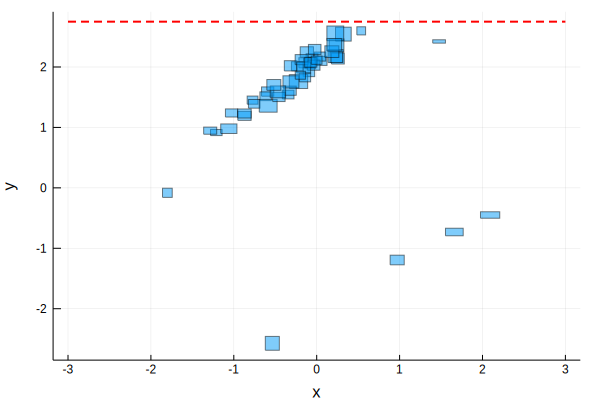

In [240]:
plot(Rsol, xlab="x", ylab="y", alpha=.5, indices=1:1000:nsets)
plot!(x->x, x->2.75, -3., 3., line=2, color="red", linestyle=:dash, legend=nothing)

In [226]:
# check that specification holds
@assert all([ρ([0.0, 1.0], Rsol.Xk[i].X) < 2.75 for i in eachindex(Rsol.Xk)])

AssertionError: AssertionError: all([ρ([0.0, 1.0], (Rsol.Xk[i]).X) < 2.75 for i = eachindex(Rsol.Xk)])

In [227]:
maximum([ρ([0.0, 1.0], Rsol.Xk[i].X) for i in eachindex(Rsol.Xk)])

3.0296234875392427

In [ ]:
any([Rsol.Xk[i].X ⊆ Rsol.Xk[1].X for i in 2:nsets])

### Appendix: auxiliary functions

In [19]:
function linearize(𝑃::IVP{<:BBCS}, δ)

    # nonlinear ODE
    f = 𝑃.s.f
    
    # initial set of current chunk
    𝑋₀i = 𝑃.x0

    # linearization point for current chunk
    c = center(𝑋₀i)
    x̃ = c + δ/2 * f(c)

    # evaluate Jacobian at the linearization point
    Ax̃ = jacobian(f, x̃) #  map(x -> evaluate(x, x̃), Jf)
    bx̃ = f(x̃) - Ax̃ * x̃

    # instantiate linearized system; it doesn't have state constraints
    𝑆lin = ConstrainedAffineContinuousSystem(Ax̃, bx̃, Universe(2));
    𝑃lin = IVP(𝑆lin, 𝑋₀i)
    return x̃, 𝑃lin
end

linearize (generic function with 1 method)

In [20]:
function _add_chunk!(Rsets::Vector{ReachSet{Hyperrectangle{Float64}, Float64}}, Rlin, R̄err, t0)
    #println("using hyperrect")
    @inbounds for i in eachindex(Rlin.Xk)
        Ri = Rlin.Xk[i].X ⊕ R̄err
        Ri = overapproximate(Ri, Hyperrectangle)
        Ri = ReachSet(Ri, t0 + Rlin.Xk[i].t_start, t0 + Rlin.Xk[i].t_end)
        push!(Rsets, Ri)
    end
    return Rsets
end

function _add_chunk!(Rsets::Vector{ReachSet{Zonotope{Float64}, Float64}}, Rlin, R̄err, t0)
    #println("using zonotopes")
    @inbounds for i in eachindex(Rlin.Xk)
        Ri = minkowski_sum(Rlin.Xk[i].X, convert(Zonotope, R̄err))
        Ri = ReachSet(Ri, t0 + Rlin.Xk[i].t_start, t0 + Rlin.Xk[i].t_end)
        push!(Rsets, Ri)
    end
    return Rsets
end

_add_chunk! (generic function with 2 methods)

In [21]:
function admissible_error(Ax̃, δ, θ; n=2)
    @assert n == 2
    Φ₁_Aδ = Φ₁(Ax̃, δ)
    R̄err = Hyperrectangle(zeros(2), θ*δ)
    l̄ = abs.(inv(Φ₁_Aδ)) * θ * δ
    L̄ = Hyperrectangle(zeros(2), l̄)
    return R̄err, L̄
end

admissible_error (generic function with 1 method)

In [22]:
function lagrange_remainder(f, Rlin, R̄err, x̃; n=2)
    @assert n == 2
    
    Hf₁ = [∂(f[1], (2, 0)) ∂(f[1], (1, 1));
           ∂(f[1], (1, 1)) ∂(f[1], (0, 2))]
    Hf₂ = [∂(f[2], (2, 0)) ∂(f[2], (1, 1));
           ∂(f[2], (1, 1)) ∂(f[2], (0, 2))]

    R̂lin = ConvexHullArray([Ri.X for Ri in Rlin.Xk]) ⊕ R̄err
    R̂lin_rect = overapproximate(R̂lin, Hyperrectangle)

    ξ = CH(Singleton(x̃), R̂lin_rect)
    ξ_rect = overapproximate(ξ, Hyperrectangle)
    ξ_box = convert(IntervalBox, ξ_rect)

    Hf₁_box = map(Hf_ij -> evaluate(Hf_ij, ξ_box), Hf₁)
    Hf₂_box = map(Hf_ij -> evaluate(Hf_ij, ξ_box), Hf₂)

    R̂lin_zono = convert(Zonotope, R̂lin_rect)

    γ = abs.(R̂lin_zono.center - x̃) + sum(abs.(R̂lin_zono.generators), dims=2)
    
    G = [sup.(abs.(Hf₁_box)), sup.(abs.(Hf₂_box))];
    li_zono = [(1/2 * transpose(γ) * G[i] * γ)[1, 1] for i in 1:n]
    L = Hyperrectangle(zeros(n), li_zono)
    return L
end

lagrange_remainder (generic function with 1 method)

### Other scripts

In [23]:
#=
@time begin
# number of Taylor terms considered in the linearization
taylor_terms = 4

# define the working variables and fix the max order in the Taylor series expansion
x = set_variables("x", numvars=2, order=taylor_terms)

# define the ODE
f = Vector{TaylorN{Float64}}(undef, 2)
f[1] = x[2]
f[2] = x[2] * (1-x[1]^2) - x[1]

# define the initial-value problem
𝑋₀ = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45])
𝑆 = BlackBoxContinuousSystem(f, 2)
𝑃 = InitialValueProblem(𝑆, 𝑋₀)

# take the gradient of the vector field symbolically
#∇f = [gradient(f[i]) for i in 1:2]

# take the Jacobian matrix of the vector field symbolically
#Jf = [∂(f[1], (1, 0)) ∂(f[1], (0, 1));
#      ∂(f[2], (1, 0)) ∂(f[2], (0, 1))]

# algorithm-specific options
𝑂 = Options(:δ => 0.02, :δcont => 0.02/10, :max_order=>2, :θ=>fill(0.05, 2))

# unwrap options
δ = O[:δ]
θ = O[:θ]

# collection of flowpipes; the set type depends on add_chunk! and the continuous post
Rsets = Vector{ReachSet{Hyperrectangle{Float64}, Float64}}()
end
=#

In [24]:
#=
@time begin
x̃, 𝑃lin = linearize(𝑃, δ)
end;
𝑋₀i = 𝑃lin.x0

# use zonotope-based continuous reach
@time begin
Rlin_zono = solve(𝑃lin, Options(:T=>O[:δ]), op=GLGM06(:δ=>O[:δcont], :max_order=>O[:max_order]))
end;

# use decomposition-based continuous reach
@time begin
Rlin_box = solve(𝑃lin, Options(:T=>O[:δ]), op=BFFPSV18(:δ=>O[:δcont]))
end;

plot(Rlin_zono, alpha=.5)
plot!(Rlin_box, alpha=.5, xlab="x", ylab="y")

Rlin = Rlin_zono  # decide which continuoust post to use

@time begin
R̄err, L̄ = admissible_error(𝑃lin.s.A, δ, θ; n=2)
L = lagrange_remainder(f, Rlin, R̄err, x̃; n=2)
end
=#